In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
import os
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import pingouin as pg

# для диагностики моделей
from yellowbrick.regressor import ResidualsPlot, PredictionError
import statsmodels.stats.api as sms

# для визуализации 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick
from graphviz import Source
from sklearn.tree import export_graphviz

%config InlineBackend.figure_format = 'svg'
plt.style.use('classic')
sns.set_style('whitegrid')
sns.set()

import warnings
warnings.filterwarnings("ignore")

C:\Users\Админ\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


**Функция для подсчета метрик**

In [2]:
def median_absolute_percentage_error(y_pred, y_real):
    MedAPE = np.median(np.abs((y_real - y_pred)/y_real))*100
    return MedAPE
def mean_absolute_percentage_error(y_pred, y_real):
    MAPE = (np.sum(np.abs(y_real-y_pred)/y_pred))*100/len(y_pred)
    return MAPE
def metrics(y_pred,y_test):
    MedAPE = median_absolute_percentage_error(y_pred,y_test)
    MAPE = mean_absolute_percentage_error(y_pred, y_test)
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MedAE = median_absolute_error(y_test, y_pred)
    r_2 = r2_score(y_test, y_pred)
    print("R^2: ", round(r_2,3))
    print("MedAPE: ", round(MedAPE,3))
    print("MAPE: ", round(MAPE,3))
    print("MAE: ", round(MAE,3))
    print("RMSE: ", round(RMSE,3))
    print("MedAE: ", round(MedAE,3))

In [3]:
data = pd.read_excel('ETAGI.xlsx', index_col=0)
data = data.drop(['districttr', 'lon', 'lat', 'flatId', 'keep', 'balcon', 'address','region', 'priceM', 'bath'], axis=1)

In [4]:
data.head()

,price,rooms,area,floor,floors_in_house,building_year,wall_id,euro,mortgage,ceiling_height,...,internet,telephon,tv,dist_centr,keepLabel,balconLabel,bathLabel,regionLabel,districttr_label,districttr_priceM
0,10500000,3,67,9,10,2002,12,0,0,3,...,1,1,1,7,2,1,1,2,6,166723.463415
1,11800000,3,72,3,5,2003,12,0,0,2,...,1,1,1,4,2,1,1,2,6,166723.463415
2,3450000,1,18,5,9,1977,11,0,0,2,...,1,1,1,4,2,0,0,3,6,166723.463415
3,5000000,1,26,2,5,1965,11,0,1,2,...,1,1,1,5,2,1,1,2,6,166723.463415
4,4600000,1,35,6,27,2020,64,1,0,2,...,1,1,1,9,0,1,0,2,6,166723.463415


# ЛИНЕЙНАЯ РЕГРЕССИЯ

Для модели линейной регрессии категориальные переменные закодируем с помощью метода one-hot-encoding, в данном варианте получилось 66 объясняющих переменных. Также значения переменных были нормализованы – приведены к единому масштабу от 0 до 1.

In [5]:
dummy = pd.get_dummies(data)

In [6]:
scaler = preprocessing.MinMaxScaler()

names = dummy.columns
d_MinMaxScaler = scaler.fit_transform(dummy)

dummy = pd.DataFrame(d_MinMaxScaler, columns=names)

In [7]:
dummy.head()

,price,rooms,area,floor,floors_in_house,building_year,wall_id,euro,mortgage,ceiling_height,...,internet,telephon,tv,dist_centr,keepLabel,balconLabel,bathLabel,regionLabel,districttr_label,districttr_priceM
0,0.478022,0.5,0.335260,0.333333,0.209302,0.818182,0.002513,0.0,0.0,0.333333,...,1.0,1.0,1.0,0.28,0.666667,0.5,1.0,0.50,0.2,0.583116
1,0.549451,0.5,0.364162,0.083333,0.093023,0.827273,0.002513,0.0,0.0,0.000000,...,1.0,1.0,1.0,0.16,0.666667,0.5,1.0,0.50,0.2,0.583116
2,0.090659,0.0,0.052023,0.166667,0.186047,0.590909,0.000000,0.0,0.0,0.000000,...,1.0,1.0,1.0,0.16,0.666667,0.0,0.0,0.75,0.2,0.583116
3,0.175824,0.0,0.098266,0.041667,0.093023,0.481818,0.000000,0.0,1.0,0.000000,...,1.0,1.0,1.0,0.20,0.666667,0.5,1.0,0.50,0.2,0.583116
4,0.153846,0.0,0.150289,0.208333,0.604651,0.981818,0.133166,1.0,0.0,0.000000,...,1.0,1.0,1.0,0.36,0.000000,0.5,0.0,0.50,0.2,0.583116


In [9]:
X = dummy.drop('price', axis=1)
y = dummy.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)

In [10]:
new_model = LinearRegression().fit(X_train, y_train)
y_pred = new_model.predict(X_test)
metrics(y_test, y_pred)

R^2:  0.806
MedAPE:  11.582
MAPE:  14.922
MAE:  1086312.396
RMSE:  1465584.045
MedAE:  839562.266


Коэффициент детерминации модели равен 0.806. Это означает, что модель объясняет 80,6% дисперсии зависимой переменной. 

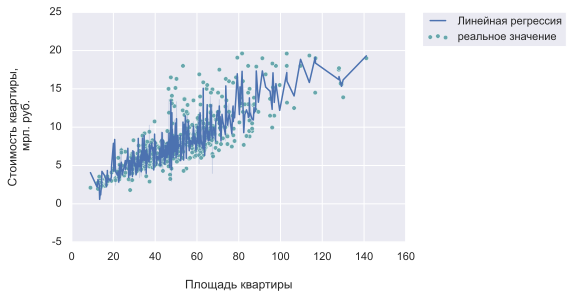

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=X_test['area'], y=y_test, ax=ax,color='#68A7AD',label='реальное значение')
sns.lineplot(x=X_test['area'], y=y_pred,label='Линейная регрессия', ax=ax)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.set_xlabel('\nПлощадь квартиры')
plt.ylabel('Стоимость квартиры,\n мрл. руб.\n')
plt.title('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Из рисунка выше, на котором изображена аппроксимация данных обучающей выборки, видно, что модель Линейной регрессии переобучена. Модель сильно подстраивается под данные обучающей выборки.

**Диагностика модели Линейная регрессия**

In [12]:
resids = y_pred - y_test
hb = sms.het_breuschpagan(resids,X_test)

In [13]:
hb

(98.61659361553183,
 0.008992959997397569,
 1.8264844049026518,
 0.0003781530052682311)

In [14]:
pg.normality(resids)

,W,pval,normal
price,0.968141,3.888065e-09,False


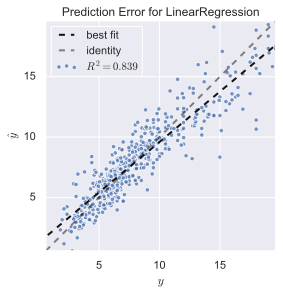

In [15]:
# График ошибки прогноза
fig, ax = plt.subplots(figsize=(6,4))
rpv = PredictionError(new_model)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

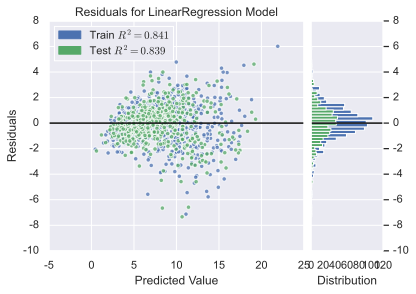

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
rpv = ResidualsPlot(new_model)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

Диагностика модели линейная регрессия показала, что остатки модели линейная регрессия гетероскедастичны. Тест Бройша-Пагана (p-value равно 0.0038) показал, что нулевая гипотеза гомоскедастичности отвергается на уровне значимости 0,05. Это указывает на то, что остатки гетероскедастичны, а прогнозы смещены.

## Дерево решений

Гиперпараметры модели дерево решений выберем с помощью случайного поиска по сетке. Случайный поиск показал, что минимальное число объектов, необходимое для того, чтобы узел дерева мог расщепиться равный 30, и минимальное число объектов в листьях равное 10, глубина дерева 184, являются оптимальными гиперпараметрами.

In [17]:
X = data.drop('price', axis=1)
y = data.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)

In [18]:
reg = tree.DecisionTreeRegressor()

max_depth = [int(x) for x in range(0,200)]
min_samples_split = [int(x) for x in range(0,110,10)]
min_samples_leaf = [int(x) for x in range(0,110,10)]
param_dist =  {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rs = RandomizedSearchCV(reg, 
                        param_dist, 
                        n_iter = 1000, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=42)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   10.7s finished


{'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 180}

In [19]:
clf = tree.DecisionTreeRegressor(splitter='best',
                                     min_samples_split = 30,
                                     min_samples_leaf = 10,
                                     max_features = 'auto',
                                     criterion = 'friedman_mse',
                                     max_depth = 180)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics(y_pred,y_test)

R^2:  0.762
MedAPE:  11.979
MAPE:  15.235
MAE:  1241935.8
RMSE:  1790656.65
MedAE:  869687.5


In [20]:
feature_importance = clf.feature_importances_
feature_importances_df = pd.DataFrame({'features':list(X),
                                       'feature_importance':feature_importance})
feature_importances_df = feature_importances_df.sort_values('feature_importance', ascending = False)

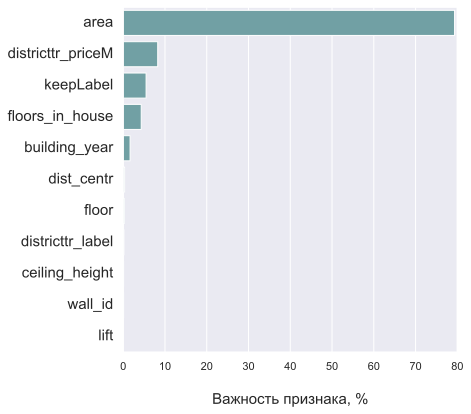

In [21]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sns.barplot(data=feature_importances_df.query("feature_importance>0"),x='feature_importance',y='features',ax=ax, color='#68A7AD')
plt.xlabel('\nВажность признака, %', fontsize=15)
plt.ylabel('', fontsize=15)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
ax.xaxis.set_major_formatter(ticks_x)
plt.yticks(fontsize=15)
plt.show()

Коэффициент детерминации модели дерево решений равен 76,2%. В среднем модель ошибается на 15,2%. Средняя абсолютная ошибка модели равна 1 241 935,8 рублей. Из рисунка, можно сделать вывод о том, что наибольший вклад оказывает признак площади объекта, а также средняя стоимость квадратного метра по району, тип ремонта, год постройки дома, количество этажей в доме, этаж.

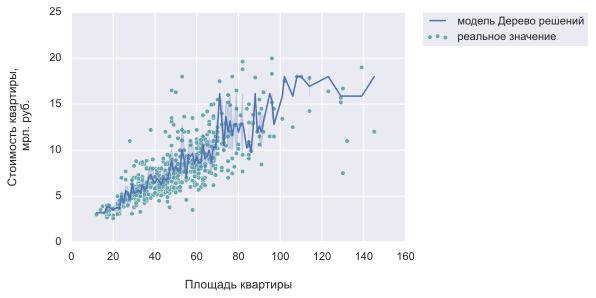

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=X_test['area'], y=y_test, ax=ax,color='#68A7AD',label='реальное значение')
sns.lineplot(x=X_test['area'], y=y_pred,label='модель Дерево решений', ax=ax)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.set_xlabel('\nПлощадь квартиры')
plt.ylabel('Стоимость квартиры,\n мрл. руб.\n')
plt.title('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Дерево Решений плохо справляется с объектами, площадь который более 100 м кв. 

**Диагностика модели Дерево решений**

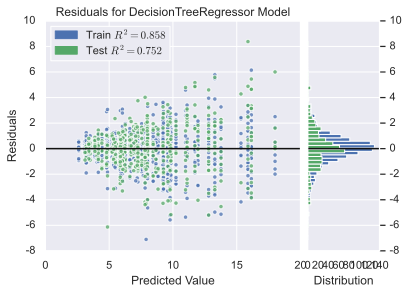

In [23]:
fig, ax = plt.subplots(figsize=(6,4))
rpv = ResidualsPlot(clf)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

In [24]:
resids = y_pred - y_test
hb = sms.het_breuschpagan(resids,X_test)

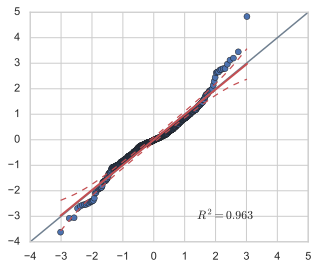

In [25]:
# Нормальные остатки
sns.set_style('whitegrid')
pg.qqplot(resids)
plt.xlabel('')
plt.ylabel('')
plt.title('');

In [26]:
#тест Колмогорова-Смирнова
pg.normality(resids)

,W,pval,normal
price,0.964899,4.609536e-10,False


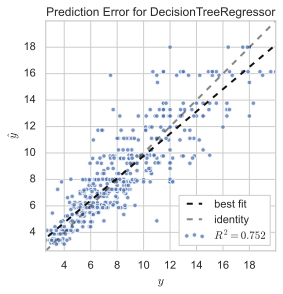

In [27]:
# График ошибки прогноза
fig, ax = plt.subplots(figsize=(6,4))
rpv = PredictionError(clf)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

Теста Бройша-Пагана (p-value равно 1.492060672099805e-19) и рисунки указывают на то, что остатки гетероскедастичны, а прогнозы смещены.

# Случайный лес

Гиперпараметры модели случайный лес были выбраны с помощью случайного поиска по сетке. 

In [28]:
reg = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(reg, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.8s finished


{'n_estimators': 700,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

Минимальное число объектов, необходимое для того, чтобы узел дерева мог расщепиться равный 12, и минимальное число объектов в листьях равное 2, глубина дерева 13, число деревьев - 700, являются оптимальными гиперпараметрами.

In [29]:
best_clf = rs.best_estimator_ 
y_pred = best_clf.predict(X_test)
metrics(y_pred,y_test)

R^2:  0.839
MedAPE:  8.758
MAPE:  11.872
MAE:  980669.1
RMSE:  1383158
MedAE:  680347


Коэффициент детерминации модели случайный лес равен 83,9%. В среднем модель ошибается на 11,8%. Средняя абсолютная ошибка модели равна 980 669 рублей. 

In [30]:
feature_importance = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features':list(X),
                                       'feature_importance':feature_importance})
feature_importances_df = feature_importances_df.sort_values('feature_importance', ascending = False)

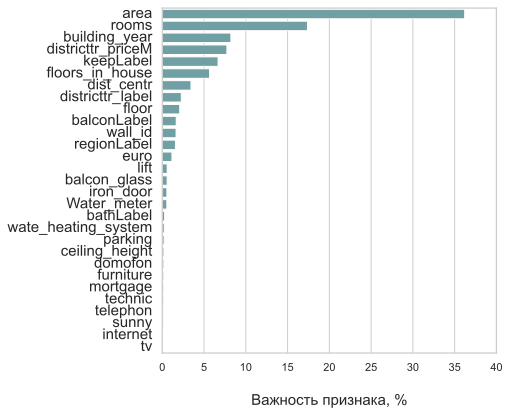

In [31]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sns.barplot(data=feature_importances_df.query("feature_importance>0"),x='feature_importance',y='features',ax=ax, color='#68A7AD')
plt.xlabel('\nВажность признака, %', fontsize=15)
plt.ylabel('', fontsize=15)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
ax.xaxis.set_major_formatter(ticks_x)
plt.yticks(fontsize=15)
plt.show()

Наибольший вклад оказывают также признаки – площадь объекта, средняя стоимость квадратного метра по району, тип ремонта, год постройки дома, количество этажей в доме, этаж, а также количество комнат, микрорайон, район, тип балкона, стен и т. д.

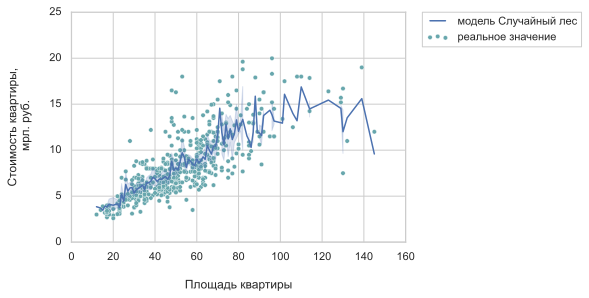

In [32]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=X_test['area'], y=y_test, ax=ax,color='#68A7AD',label='реальное значение')
sns.lineplot(x=X_test['area'], y=y_pred,label='модель Случайный лес', ax=ax)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.set_xlabel('\nПлощадь квартиры')
plt.ylabel('Стоимость квартиры,\n мрл. руб.\n')
plt.title('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

модель случайный лес лучше справляется с квартирами, площадью больше 100 м2, нежели модель дерево решений.

**Диагностика модели Случайный лес**

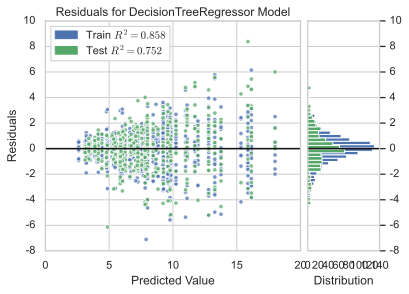

In [33]:
fig, ax = plt.subplots(figsize=(6,4))
rpv = ResidualsPlot(clf)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

In [34]:
resids = y_pred - y_test
hb = sms.het_breuschpagan(resids,X_test)

In [35]:
hb

(179.7977384949574,
 4.254514497769995e-24,
 9.483996622148824,
 9.772974881991376e-31)

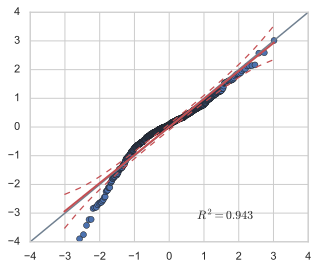

In [36]:
# Нормальные остатки
sns.set_style('whitegrid')
pg.qqplot(resids)
plt.xlabel('')
plt.ylabel('')
plt.title('');

In [37]:
#тест Колмогорова-Смирнова
pg.normality(resids)

,W,pval,normal
price,0.944674,2.600978e-13,False


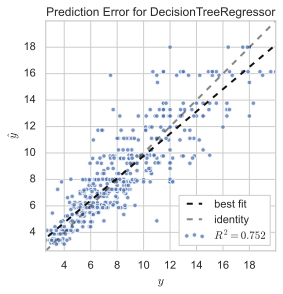

In [38]:
# График ошибки прогноза
fig, ax = plt.subplots(figsize=(6,4))
rpv = PredictionError(clf)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

Остатки модели случайный лес являются гетероскедостичными

# Градиентный бустинг

Гиперпараметры модели градиентный бустинг выберем с помощью случайного поиска по сетке. Случайный поиск показал, что минимальное число объектов, необходимое для того, чтобы узел дерева мог расщепиться равный 39, и минимальное число объектов в листьях равное 2, глубина дерева 3, количество деревьев равно 300, являются лучшими гиперпараметрами.

In [39]:
RGB = GradientBoostingRegressor()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rs = RandomizedSearchCV(RGB, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   28.4s finished


{'n_estimators': 300,
 'min_samples_split': 39,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 3}

In [40]:
best_RGB  = GradientBoostingRegressor(n_estimators = 300,
                                      min_samples_split = 39,
                                      min_samples_leaf = 2,
                                      max_features = 'sqrt',
                                      max_depth = 3) 
best_RGB.fit(X_train,y_train)
y_pred = best_RGB.predict(X_test)
metrics(y_pred, y_test)

R^2:  0.855
MedAPE:  9.684
MAPE:  12.272
MAE:  976608.8
RMSE:  1393739.54
MedAE:  698790.28


Коэффициент детерминации модели градиентный бустинг равен 85,5%. В среднем модель ошибается на 12%. Средняя абсолютная ошибка модели равна 976 608 рублей. 

In [41]:
feature_importance = best_RGB.feature_importances_
feature_importances_df = pd.DataFrame({'features':list(X),
                                       'feature_importance':feature_importance})
feature_importances_df = feature_importances_df.sort_values('feature_importance', ascending = False)

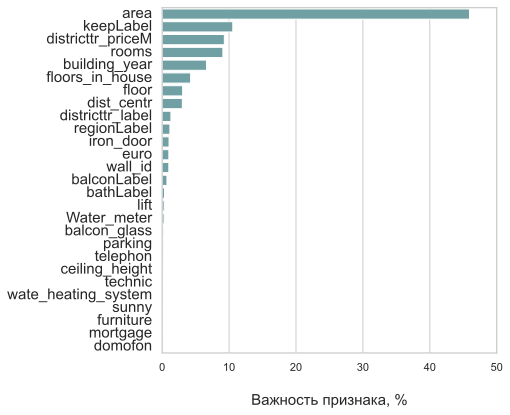

In [42]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sns.barplot(data=feature_importances_df.query("feature_importance>0"),x='feature_importance',y='features',ax=ax, color='#68A7AD')
plt.xlabel('\nВажность признака, %', fontsize=15)
plt.ylabel('', fontsize=15)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
ax.xaxis.set_major_formatter(ticks_x)
plt.yticks(fontsize=15)
plt.show()

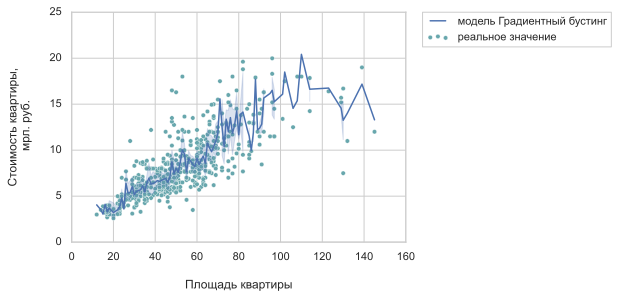

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=X_test['area'], y=y_test, ax=ax,color='#68A7AD',label='реальное значение')
sns.lineplot(x=X_test['area'], y=y_pred,label='модель Градиентный бустинг', ax=ax)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.set_xlabel('\nПлощадь квартиры')
plt.ylabel('Стоимость квартиры,\n мрл. руб.\n')
plt.title('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

**Диагностика модели Градиентный бустинг**

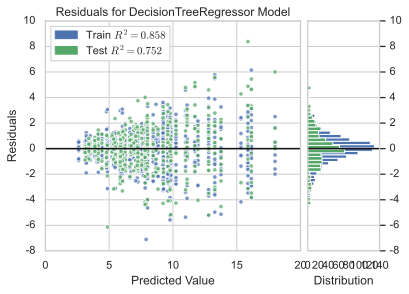

In [44]:
fig, ax = plt.subplots(figsize=(6,4))
rpv = ResidualsPlot(clf)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

In [45]:
resids = y_pred - y_test
hb = sms.het_breuschpagan(resids,X_test)

In [46]:
hb

(177.95088807398164,
 9.38287707864271e-24,
 9.338696773537574,
 3.1944050512081096e-30)

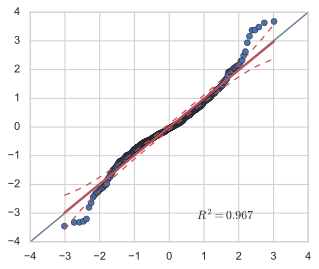

In [47]:
# Нормальные остатки
sns.set_style('whitegrid')
pg.qqplot(resids)
plt.xlabel('')
plt.ylabel('')
plt.title('');

In [48]:
#тест Колмогорова-Смирнова
pg.normality(resids)

,W,pval,normal
price,0.968185,1.986621e-09,False


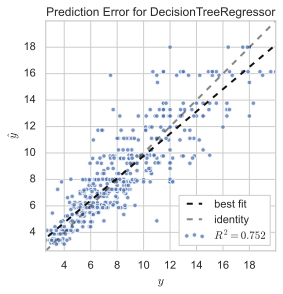

In [49]:
# График ошибки прогноза
fig, ax = plt.subplots(figsize=(6,4))
rpv = PredictionError(clf)
rpv.fit(X_train, y_train)
rpv.score(X_test,y_test)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('')
rpv.poof();

Остатки модели случайный лес являются гетероскедостичными

# CATBOOST

In [50]:
cat = CatBoostRegressor()
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
y_pred = cat.predict(X_test)
metrics(y_pred,y_test)

R^2:  0.864
MedAPE:  8.668
MAPE:  11.328
MAE:  902700
RMSE:  1305429
MedAE:  612055


Коэффициент детерминации модели машинного обучения равен 86,4%. В среднем модель ошибается на 11%. Средняя абсолютная ошибка модели равна 902 700 рублей. 

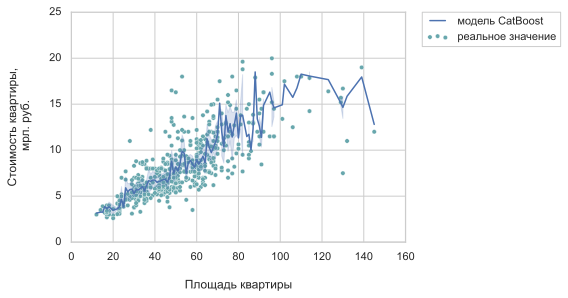

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=X_test['area'], y=y_test, ax=ax,color='#68A7AD',label='реальное значение')
sns.lineplot(x=X_test['area'], y=y_pred,label='модель CatBoost', ax=ax)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.set_xlabel('\nПлощадь квартиры')
plt.ylabel('Стоимость квартиры,\n мрл. руб.\n')
plt.title('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [56]:
feature_importance = best_RGB.feature_importances_
feature_importances_df = pd.DataFrame({'features':list(X),
                                       'feature_importance':feature_importance})
feature_importances_df = feature_importances_df.sort_values('feature_importance', ascending = False)

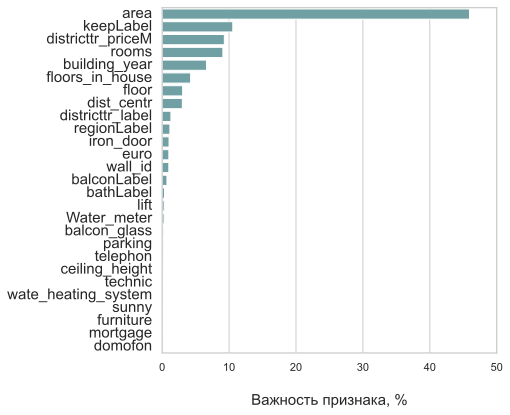

In [57]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sns.barplot(data=feature_importances_df.query("feature_importance>0"),x='feature_importance',y='features',ax=ax, color='#68A7AD')
plt.xlabel('\nВажность признака, %', fontsize=15)
plt.ylabel('', fontsize=15)
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
ax.xaxis.set_major_formatter(ticks_x)
plt.yticks(fontsize=15)
plt.show()

Наибольший вклад в данную модель вносит признак, указывающий на площадь квартиры (51,2%), наименьший – наличие домофона (0,0013%).


**Диагностика модели Catboost**

In [58]:
resids = y_pred - y_test
hb = sms.het_breuschpagan(resids,X_test)

In [59]:
hb

(179.3690287323737,
 5.112526598377093e-24,
 9.450135505377867,
 1.2874666983175482e-30)

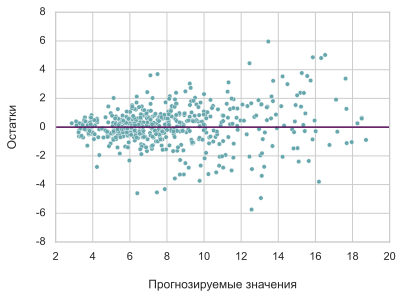

In [60]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=y_pred, y=resids, ax=ax,color='#68A7AD')
plt.axhline(1, c='#570A57')
ticks_x = tick.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1_000_000))
ax.yaxis.set_major_formatter(ticks_x)
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xlabel('\nПрогнозируемые значения')
plt.ylabel('Остатки\n')
plt.title('');

# ВЫВОД

    В ходе данной работы были изучены модели машинного обучения и применены для предсказания цены объектов рынка жилой вторичной недвижимости города Владивосток. Всего были рассмотрены 5 моделей.

    Наилучшей обобщающей способностью обладает метод машинного обучений CatBoost. Он способен объяснить 86,4% изменчивости цены и в среднем он ошибается в 8,67% случаев. 

    Худший прогноз показывает модель дерево решений, способная предсказать только 76% изменчивости цены объектов и в среднем ошибается в 12% случаев. Данная модель плохо справляется с объектами, площадь который более 100 м2. 

    Также в ходе данного исследования на основе анализа значимости независимых переменных во всех рассмотренных моделях было выявлено, что наиболее влиятельными переменными являются площадь объекта, количество комнат, средняя цена по микрорайону, тип ремонта, год постройки и его этажность, а также расстояние до центра города.
